In [1]:
import sys
sys.path.insert(0,'..')
import os
import glob
import tensorflow as tf
from tensorflow import keras
from tensorflow_addons.metrics import F1Score
from openslide import open_slide
import numpy as np
import pickle
from skimage.color import rgb2gray
import cv2
from tqdm.notebook import tqdm, trange
import matplotlib.pyplot as plt
import utils
import create_training_slices

2022-11-18 10:59:07.320754: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-18 10:59:07.852679: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-11-18 10:59:08.109898: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-18 10:59:09.848601: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

Things I tried but failed:
1. save patches to disk - so large and very slow, takes ~40 minutes
2. using cache() - 16min -> 14min
3. not using step size in create_test_dataset - 16min

In [2]:
def read_slide_mask(d):
    """Read images and mask paths from d
    
    Assumption:
        the directory contains pairs of slide/masks .tif images
    
    Args:
        d (str): directory that contains tif images of slides and masks
    
    Returns:
        a list of tuples that looks like [(slide_path, mask_path), ...]
    """
    files = glob.glob(os.path.join(d, "*.tif"))
    slides, masks = [], []
    for f in files:
        if os.path.splitext(f)[0].endswith("mask"):
            masks.append(f)
        else:
            slides.append(f)
    slides.sort()
    masks.sort()
    return list(zip(slides, masks)) 

In [3]:
def plot_slide_mask(slide_im, mask_im):
    """Plot slide with mask overlayed
    
    Args:
        slide_im: numpy.ndarray
        mask_im: numpy.ndarray
    """
    plt.imshow(slide_im)
    plt.imshow(mask_im, cmap='jet', alpha=0.5)

In [4]:
def create_test_dataset(slide, cur_level, down_level1, down_level2, input_size=299):
    """Create test dataset
    
    Idea:
        for all pixels in slide on cur_level (this is where we make heatmap based on)
        1. find its coordinates on cur_level1
        2. find its corresponding coordinates on down_level1, down_level2
        3. find 2 slide patches on down_level1 and down_level2, each centered at those coordinates
        4. return current coordinates (needed for plotting), 
            corresponding starting coordinates at down_level1 (needed for extracting patches) w.r.t. level 0
            corresponding starting coordinates at down_level2 (needed for extracting patches) w.r.t. level 0
    
    Assumption:
        down_level1 < down_level2 (consistent with creating training dataset)
        cur_level is quite large, say 7, so we won't explode the memory
    
    Returns:
        [[i, j], ...] - cur level
        [[x, y], ...] - down_level1
        [[x, y], ...] - down_level2
    """
    assert down_level1 < down_level2
    cur_coordinates = []
    level1_coord, level2_coord = [], []
    # careful, level_dimensions give dimensions
    # w.r.t. x, y in computer vision
    # so (736, 868) means (w, h) in numpy arrays
    cur_w, cur_h = slide.level_dimensions[cur_level]
    zoom1_w, zoom1_h = slide.level_dimensions[down_level1]
    zoom2_w, zoom2_h = slide.level_dimensions[down_level2]
    downrate_curlevel = slide.level_downsamples[cur_level]
    downrate_level1 = slide.level_downsamples[down_level1]
    downrate_level2 = slide.level_downsamples[down_level2]
    slide_im_curlevel = utils.read_entire_slide(slide, cur_level)
    cur_level_gray = rgb2gray(slide_im_curlevel)
    for i in tqdm(range(0, cur_h, 1)):
        for j in range(0, cur_w, 1):
            center_x, center_y = j, i # cur level
            center_x0, center_y0 = int(center_x * downrate_curlevel), int(center_y * downrate_curlevel) # w.r.t level 0
            
            # on down_level1
            center_x_zoom1, center_y_zoom1 = center_x0 // downrate_level1, center_y0 // downrate_level1
            start_x_zoom1, start_y_zoom1 = center_x_zoom1 - input_size // 2, center_y_zoom1 - input_size // 2
            end_x_zoom1, end_y_zoom1 = start_x_zoom1 + input_size, start_y_zoom1 + input_size
            start_x_zoom10, start_y_zoom10 = int(start_x_zoom1 * downrate_level1), int(start_y_zoom1 * downrate_level1)
            
            # on down_level2
            center_x_zoom2, center_y_zoom2 = center_x0 // downrate_level2, center_y0 // downrate_level2
            start_x_zoom2, start_y_zoom2 = center_x_zoom2 - input_size // 2, center_y_zoom2 - input_size // 2
            end_x_zoom2, end_y_zoom2 = start_x_zoom2 + input_size, start_y_zoom2 + input_size
            start_x_zoom20, start_y_zoom20 = int(start_x_zoom2 * downrate_level2), int(start_y_zoom2 * downrate_level2)
            
            # validate
            if start_x_zoom1 < 0 or start_y_zoom1 < 0 or end_x_zoom1 > zoom1_w or end_y_zoom1 > zoom1_h:
                continue
            elif start_x_zoom2 < 0 or start_y_zoom2 < 0 or end_x_zoom2 > zoom2_w or end_y_zoom2 > zoom2_h:
                continue
            elif cur_level_gray[i][j] > 0.8: # not tissue, don't care
                continue
            else:
                cur_coordinates.append([i, j]) # pay attention to the different order
                level1_coord.append([start_x_zoom10, start_y_zoom10])
                level2_coord.append([start_x_zoom20, start_y_zoom20])
    return cur_coordinates, level1_coord, level2_coord

In [5]:
def create_test_slices(slide, level1, level2, level1_coord, level2_coord, level1out, level2out, input_shape):
    """Create testing slices based on coordinates
    did not use a single function because
    1. it will be much more complicated
    2. more difficult to debug
    
    Idea:
        save patches of images to level1out and level2out, 
        each starting from index 0
        all the patches saved would correspond to the indices in cur_coordinates
        
    Args:
        slide: open-slide object
        level1 (int)
        level2 (int)
        level1_coord (list)
        level2_coord (list)
        level1out (str)
        level2out (str)
        input_shape (int)
    """
    assert len(level1_coord) == len(level2_coord)
    for i in trange(len(level1_coord)):
        level1_patch = utils.read_slide(slide, level1_coord[i][0], level1_coord[i][1], level1, input_shape, input_shape)
        level2_patch = utils.read_slide(slide, level2_coord[i][0], level2_coord[i][1], level2, input_shape, input_shape)
        cv2.imwrite(os.path.join(level1out, f"zoom1_{i}.png"), level1_patch)
        cv2.imwrite(os.path.join(level2out, f"zoom2_{i}.png"), level2_patch)

In [6]:
# specify some paths
model_path = "../checkpoints/inceptionv3_small_11_17_categorical_30.h5"
testing_dir = "../TIFs/testingTIFs"
slide_path = "../TIFs/testingTIFs/tumor_078.tif"
mask_path = "../TIFs/testingTIFs/tumor_078_mask.tif"
pred_path = "../predictions"

# need to create subdir imgs for Image Data Generator to work
testing_zoom1 = "../testing/zoom1/imgs/"
testing_zoom2 = "../testing/zoom2/imgs/"

slide = open_slide(slide_path)
mask = open_slide(mask_path)

# specify some global variables
input_shape = 299
cur_level = 7 # the level to make heatmap
down_level1 = 2
down_level2 = 3
batch_size = 32

In [7]:
# load model
model = keras.models.load_model(model_path)

2022-11-18 10:59:32.872899: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-11-18 10:59:32.950494: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-11-18 10:59:32.952198: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-11-18 10:59:32.953984: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow 

In [12]:
# create lists
cur_ij, zoom1_xy, zoom2_xy = create_test_dataset(slide, cur_level, down_level1, down_level2, input_shape)

  0%|          | 0/868 [00:00<?, ?it/s]

In [13]:
print(len(zoom1_xy))

211183


Text(0.5, 1.0, 'Zoom Level 3')

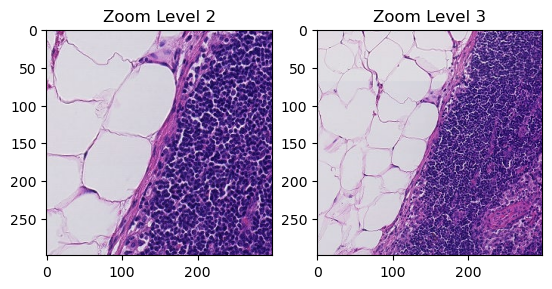

In [27]:
# verify
test_zoom1 = zoom1_xy[5000]
test_zoom2 = zoom2_xy[5000]
patch_zoom1 = utils.read_slide(slide, test_zoom1[0], test_zoom1[1], down_level1, input_shape, input_shape)
patch_zoom2 = utils.read_slide(slide, test_zoom2[0], test_zoom2[1], down_level2, input_shape, input_shape)
fig, axs = plt.subplots(1, 2)
axs[0].imshow(patch_zoom1)
axs[0].set_title(f"Zoom Level {down_level1}")
axs[1].imshow(patch_zoom2)
axs[1].set_title(f"Zoom Level {down_level2}")

In [28]:
def coord2patch1(x: np.ndarray):
    return utils.read_slide(slide, x[0], x[1], down_level1, input_shape, input_shape)

def coord2patch2(x: np.ndarray):
    return utils.read_slide(slide, x[0], x[1], down_level2, input_shape, input_shape)

# map to image patches
zoom1_xy_ds = tf.data.Dataset.from_tensor_slices(zoom1_xy)
zoom1_xy_ds = zoom1_xy_ds.map(
    lambda x: tf.numpy_function(func=coord2patch1, inp=[x], Tout=tf.uint8),
    num_parallel_calls=tf.data.AUTOTUNE
)
zoom2_xy_ds = tf.data.Dataset.from_tensor_slices(zoom2_xy)
zoom2_xy_ds = zoom2_xy_ds.map(
    lambda x: tf.numpy_function(func=coord2patch2, inp=[x], Tout=tf.uint8),
    num_parallel_calls=tf.data.AUTOTUNE
)

test_ds = tf.data.Dataset.zip(((zoom1_xy_ds, zoom2_xy_ds),))
test_ds = test_ds.batch(batch_size)
test_ds = test_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

In [29]:
# verify 
for x in test_ds.take(1).cache():
    print(x[0][0].shape)

(32, 299, 299, 3)


(299, 299, 3)
(299, 299, 3)


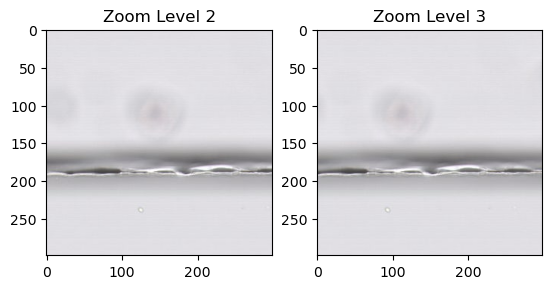

In [30]:
for x in test_ds.take(1).cache():
    x = x[0]
    zoom1, zoom2 = x[0][0], x[0][1]
    print(zoom1.shape)
    print(zoom2.shape)
    fig, axs = plt.subplots(1, 2)
    axs[0].imshow(zoom1)
    axs[0].set_title(f"Zoom Level {down_level1}")
    axs[1].imshow(zoom2)
    axs[1].set_title(f"Zoom Level {down_level2}")

In [31]:
%%time
# make prediction
y_pred = model.predict(test_ds)

6600/6600 [==============================] - 1009s 153ms/step
CPU times: user 1h 5min 24s, sys: 3min 24s, total: 1h 8min 49s
Wall time: 16min 53s


In [32]:
# save predictions
with open(os.path.join(pred_path, "vggsmall_11_17_categorical_30_step1.pkl"), "wb") as f:
    pickle.dump(y_pred, f)

In [8]:
with open(os.path.join(pred_path, "inceptionv3_small_11_17_categorical_30_step1.pkl"), "rb") as f:
    y_pred = pickle.load(f)

In [9]:
y_pred_formatted = np.argmax(y_pred, axis=1)
y_pred_formatted

array([0, 0, 0, ..., 0, 0, 0])

In [10]:
print(len(y_pred_formatted))
print(np.count_nonzero(y_pred_formatted==1))

211183
80666


In [14]:
# make heatmap
w, h = slide.level_dimensions[cur_level]
slide_cur_level = utils.read_entire_slide(slide, cur_level)
mask_cur_level = utils.read_entire_slide(mask, cur_level)[:,:,0]
pred_mask = np.zeros((h, w))
for i, y in tqdm(enumerate(y_pred_formatted)):
    pred_mask[cur_ij[i][0]][cur_ij[i][1]] = 1-y

0it [00:00, ?it/s]

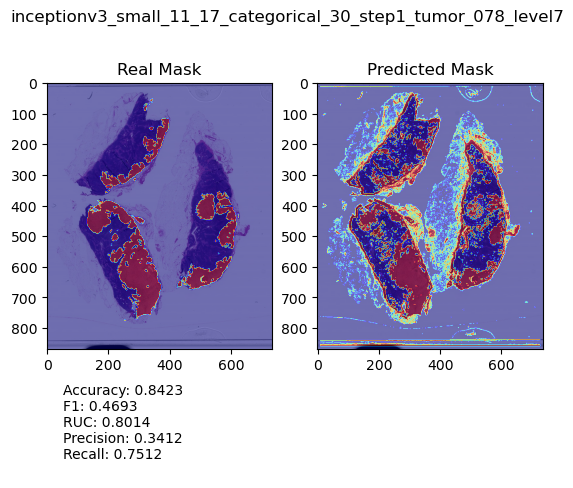

In [16]:
from sklearn import metrics

fig, axs = plt.subplots(1, 2)
axs[0].imshow(slide_cur_level, interpolation=None)
axs[0].imshow(mask_cur_level, cmap="jet", alpha=0.5)
axs[0].set_title("Real Mask")

axs[1].imshow(slide_cur_level, interpolation=None)
axs[1].imshow(pred_mask.astype("uint8"), cmap="jet", alpha=0.5)
axs[1].set_title("Predicted Mask")

fig.suptitle("inceptionv3_small_11_17_categorical_30_step1_tumor_078_level7")
fig.subplots_adjust(top=0.99)

y_true, y_pred = mask_cur_level.flatten(), pred_mask.astype("uint8").flatten()
acc = metrics.accuracy_score(y_true, y_pred)
f1 = metrics.f1_score(y_true, y_pred)
ruc = metrics.roc_auc_score(y_true, y_pred)
precision = metrics.precision_score(y_true, y_pred)
recall = metrics.recall_score(y_true, y_pred)

# txt = (f"{'Accuracy:':<20}{acc:<5.4f}\n"
#        f"{'F1:':<20}{f1:<5.4f}\n"
#        f"{'RUC:':<20}{ruc:<5.4f}\n"
#        f"{'Precision:':<20}{precision:<5.4f}\n"
#        f"{'recall:':<20}{recall:<5.4f}\n")
txt = (
    f"Accuracy: {acc:.4f}\n"
    f"F1: {f1:.4f}\n"
    f"RUC: {ruc:.4f}\n"
    f"Precision: {precision:.4f}\n"
    f"Recall: {recall:.4f}\n"
)
fig.text(0.15, 0.01, txt)
# fig.supxlabel(txt)
plt.savefig("../plots/inceptionv3_small_11_17_categorical_30_step1_tumor_078_level7.png")

In [39]:
# plot model history
history_path = "../history/vggsmall_11_17_categorical_30.pkl"
with open(history_path, "rb") as f:
    history = pickle.load(f)

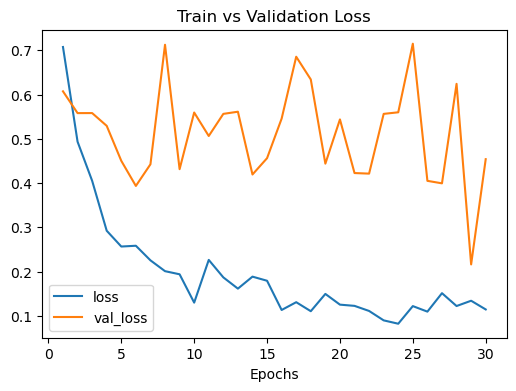

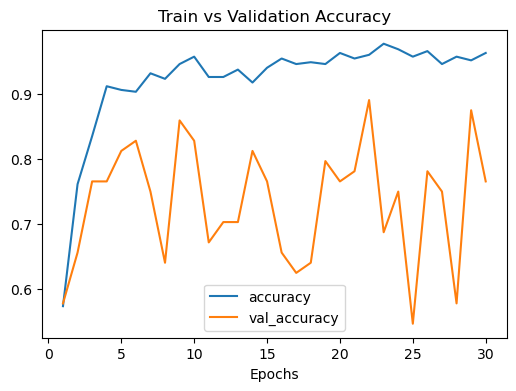

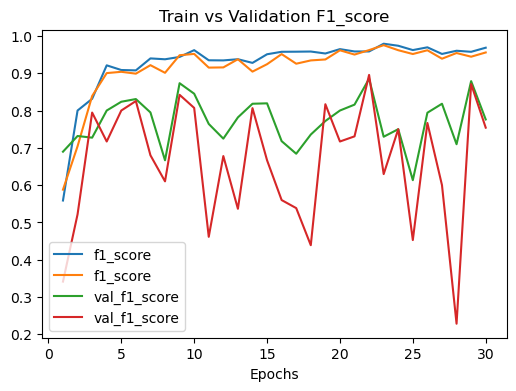

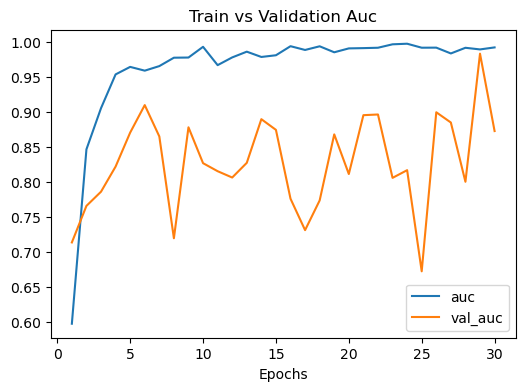

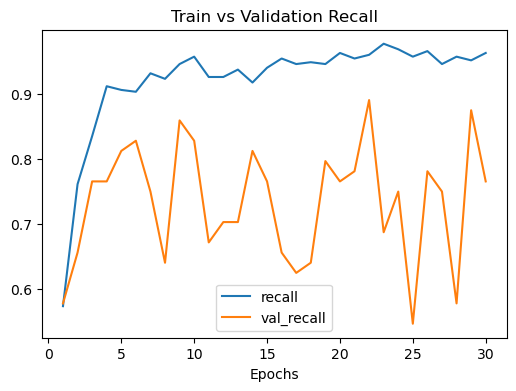

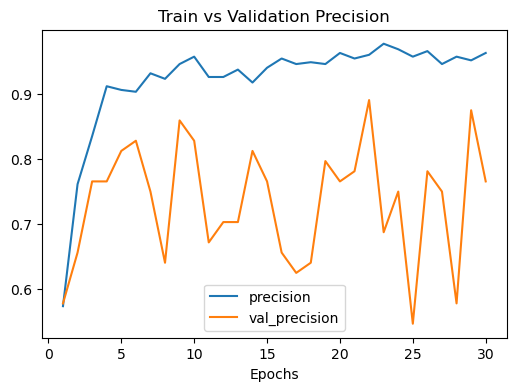

In [44]:
for k, v in history.items():
    if not k.startswith("val"):
        plt.figure(figsize=(6, 4))
        plt.plot(np.arange(1, len(v)+1), v, label=k)
        plt.plot(np.arange(1, len(v)+1), history[f"val_{k}"], label=f"val_{k}")
        plt.legend()
        plt.title(f"Train vs Validation {k.capitalize()}")
        plt.xlabel("Epochs")